# Classification of drugs by toxicity

Importing neccessary libraries

In [2]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner import Hyperband, Objective
import deepchem as dc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Using imblearn's Pipeline to include SMOTE
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

Load dataset

In [3]:
# Load dataset with ECFP featurizer
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP', split='random')
train_dataset, valid_dataset, test_dataset = datasets

'split' is deprecated.  Use 'splitter' instead.


## Deep neural networks

Data cleaning

In [4]:
# Data Cleaning: Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(train_dataset.X)
X_valid = imputer.transform(valid_dataset.X)
y_train = train_dataset.y[:, 0]  # Adjust index if targeting a specific task
y_valid = valid_dataset.y[:, 0]

Check and drop missing values in targets

In [5]:
not_nan_indices_train = ~np.isnan(y_train)
not_nan_indices_valid = ~np.isnan(y_valid)
X_train, y_train = X_train[not_nan_indices_train], y_train[not_nan_indices_train]
X_valid, y_valid = X_valid[not_nan_indices_valid], y_valid[not_nan_indices_valid]

Additional Feature Engineering: molecular weight, logP, TPSA, rotatable bonds, H-bond donors and acceptors from SMILES (Simplified Molecular Input Line Entry System) strings

In [6]:
def additional_features(smiles):
    mols = [Chem.MolFromSmiles(sm) for sm in smiles]
    features = []
    for mol in mols:
        if mol is not None:
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            tpsa = rdMolDescriptors.CalcTPSA(mol)
            rotb = Descriptors.NumRotatableBonds(mol)
            hbond_don = rdMolDescriptors.CalcNumHBD(mol)
            hbond_acc = rdMolDescriptors.CalcNumHBA(mol)
            features.append([mw, logp, tpsa, rotb, hbond_don, hbond_acc])
        else:
            features.append([np.nan]*6)  # 6 features
    return np.array(features)

train_smiles = train_dataset.ids
valid_smiles = valid_dataset.ids
train_extra_features = additional_features(train_smiles)
valid_extra_features = additional_features(valid_smiles)

[14:52:38] WARNING: not removing hydrogen atom without neighbors


Handling None values and inconsistencies

In [7]:
train_extra_features = np.nan_to_num(train_extra_features)
valid_extra_features = np.nan_to_num(valid_extra_features)

Concatenate original features with extra features before scaling

In [8]:
X_train = np.concatenate([X_train, train_extra_features], axis=1)
X_valid = np.concatenate([X_valid, valid_extra_features], axis=1)

Normalization and Scaling: apply scaling after concatenating all features

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

Balancing the Dataset

In [10]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

Variance Threshold Feature Selection: apply feature selection to the balanced dataset

In [11]:
selector = VarianceThreshold(threshold=0.1)
X_train = selector.fit_transform(X_train)
X_valid = selector.transform(X_valid)

Building a model

In [12]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = {'adam': keras.optimizers.Adam, 'sgd': keras.optimizers.SGD, 'rmsprop': keras.optimizers.RMSprop}[optimizer_choice](learning_rate=learning_rate)
    
    loss_choice = hp.Choice('loss', ['binary_crossentropy', 'hinge'])
    model.compile(optimizer=optimizer, loss=loss_choice, metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    
    return model

tuner = Hyperband(build_model, objective=Objective("val_AUC", direction="max"), max_epochs=50, directory='my_dir_2', project_name='tox21')

Reloading Tuner from my_dir_2/tox21/tuner0.json


Train model and search for the best hyperparameters

In [58]:
stop_early = EarlyStopping(monitor='val_AUC', patience=5, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_AUC', factor=0.2, patience=2, min_lr=1e-5)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=[stop_early, reduce_lr])

Evaluate model trained with best hyperparameters

In [13]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model_metrics = best_model.evaluate(X_valid, y_valid, verbose=1)
metric_names = ['loss', 'accuracy', 'AUC', 'precision', 'recall']
best_model_metrics_dict = dict(zip(metric_names, best_model_metrics))

print("Best Model Metrics on Validation Set:")
for metric, value in best_model_metrics_dict.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\nBest Hyperparameters:")
for param, val in best_hyperparameters.values.items():
    print(f"{param}: {val}")

/Users/filipnikolic/Desktop/AI in medicine/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/filipnikolic/Desktop/AI in medicine/myenv/lib/python3.12/site-packages/keras_tuner/src/tuners/hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7755 - Precision: 0.1400 - Recall: 0.6603 - accuracy: 0.8007 - loss: 1.3843
Best Model Metrics on Validation Set:
Loss: 1.3896
Accuracy: 0.7931
Auc: 0.7212
Precision: 0.1243
Recall: 0.6000

Best Hyperparameters:
input_units: 256
n_layers: 3
units_0: 96
dropout: 0.5
optimizer: sgd
learning_rate: 0.002263902578242325
loss: hinge
units_1: 192
units_2: 192
units_3: 32
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0025


Get all trial details from the tuner

In [14]:
all_trials = tuner.oracle.trials

results_data = []
for trial_id, trial in all_trials.items():
    if trial.status == 'COMPLETED':
        # Fetching all required metrics
        auc = trial.metrics.get_best_value("val_AUC")
        accuracy = trial.metrics.get_best_value("val_accuracy")
        precision = trial.metrics.get_best_value("val_Precision")
        recall = trial.metrics.get_best_value("val_Recall")
        hyperparameters = trial.hyperparameters.values
        results_data.append({
            **hyperparameters, 
            "val_AUC": auc, 
            "val_accuracy": accuracy, 
            "val_Precision": precision, 
            "val_Recall": recall
        })

results_df = pd.DataFrame(results_data)

List of metrics for looping

In [15]:
metrics = ['val_AUC', 'val_accuracy', 'val_Precision', 'val_Recall']

Generate a plot for each metric

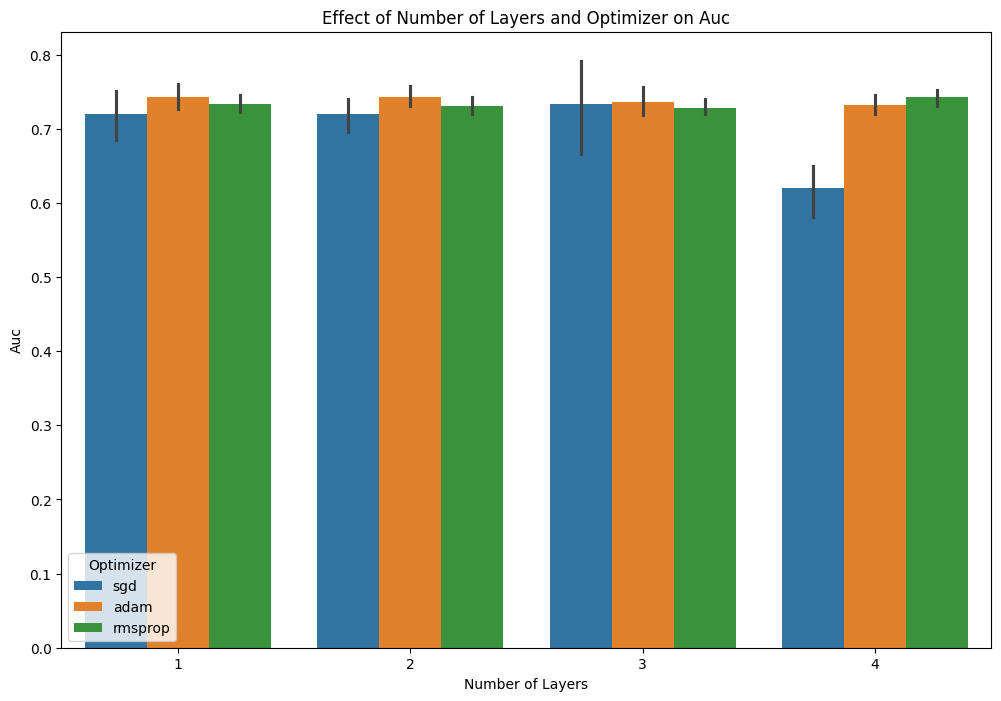

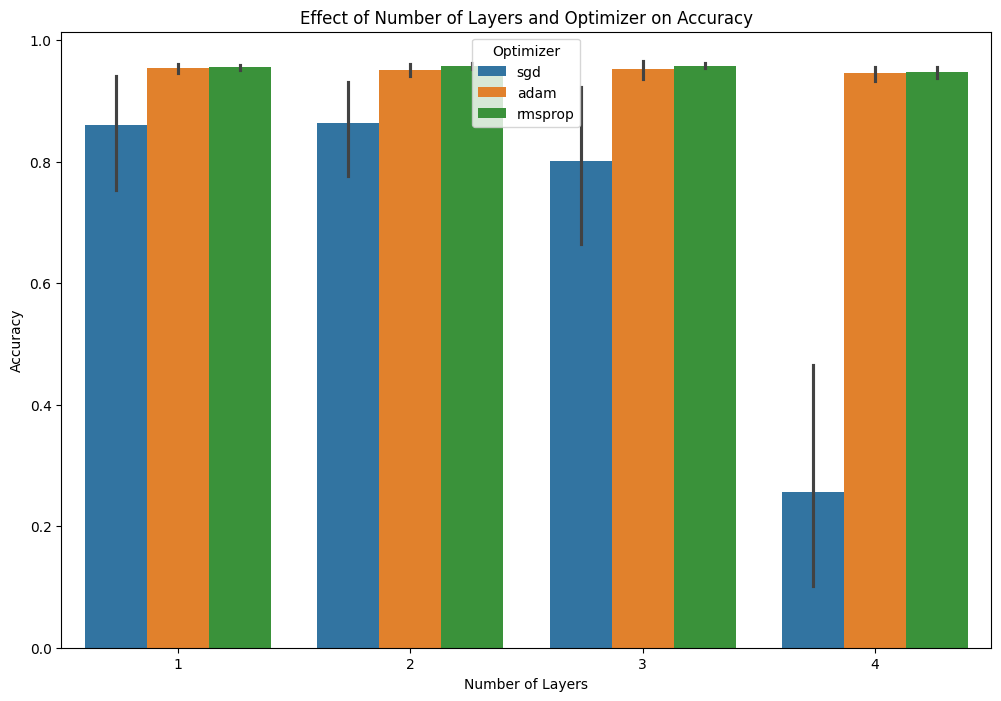

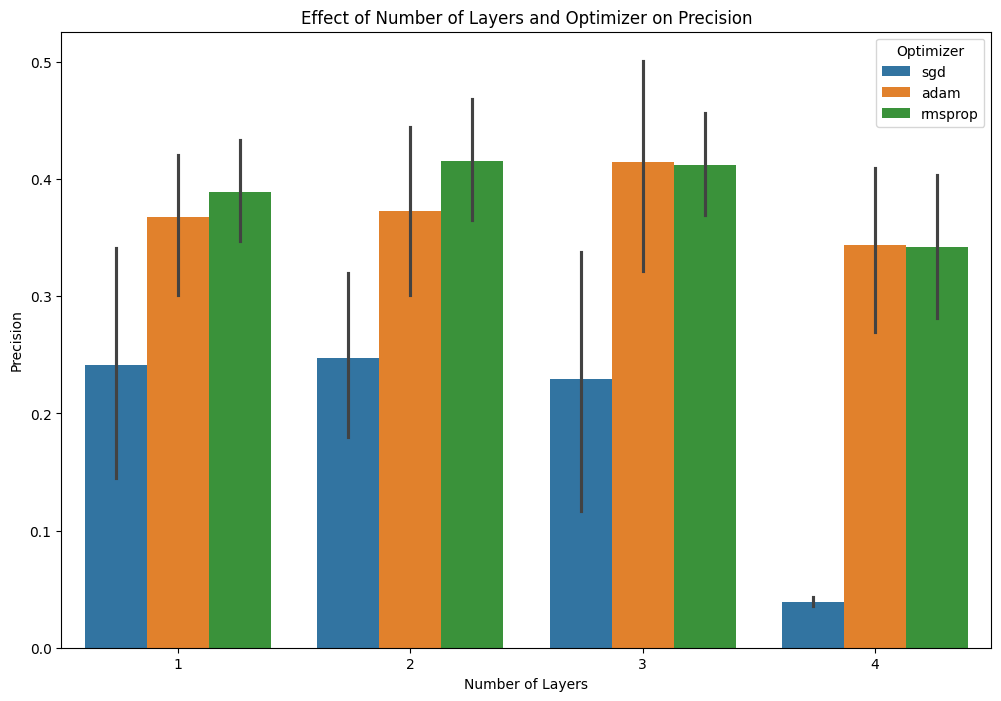

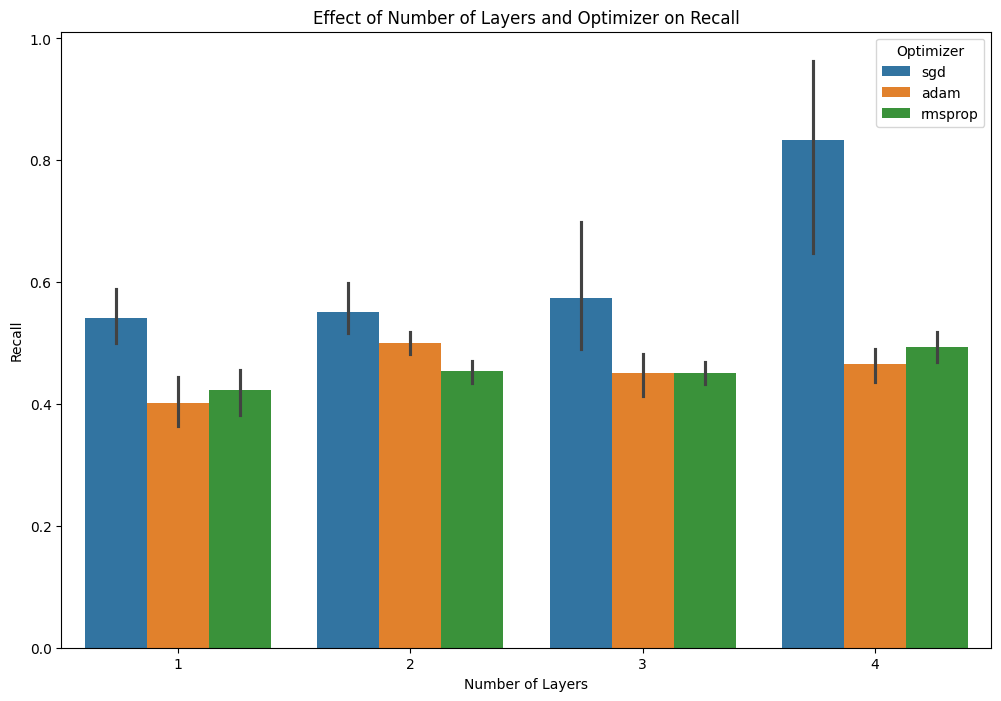

In [16]:
for metric in metrics:
    plt.figure(figsize=(12, 8))
    sns.barplot(x="n_layers", y=metric, hue="optimizer", data=results_df)
    plt.title(f"Effect of Number of Layers and Optimizer on {metric.replace('val_', '').capitalize()}")
    plt.xlabel("Number of Layers")
    plt.ylabel(metric.replace('val_', '').capitalize())
    plt.legend(title="Optimizer")
    plt.show()

Generate FacetGrids for each metric

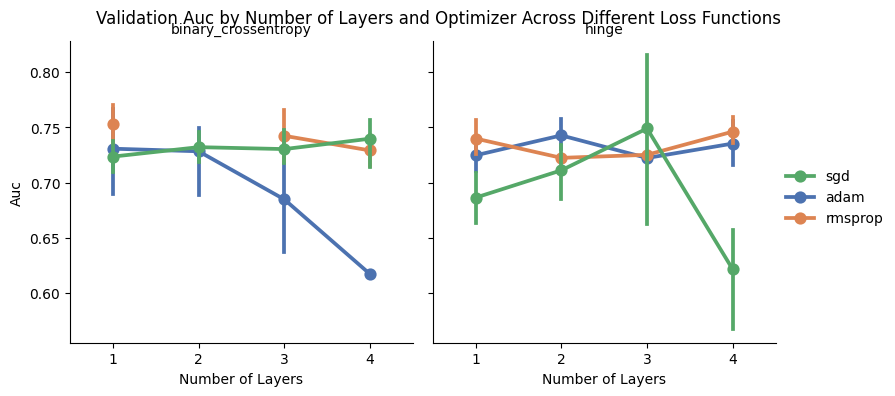

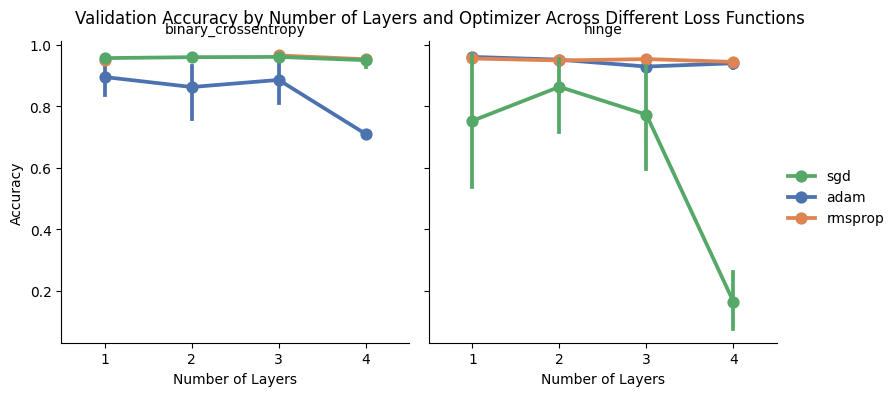

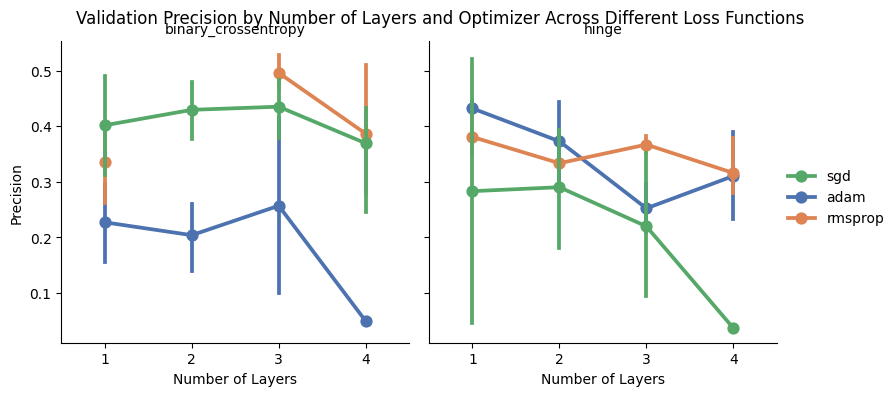

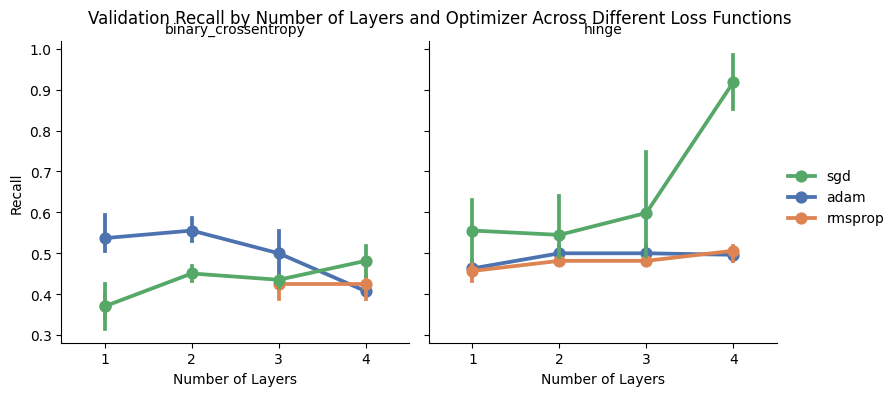

In [17]:
for metric in metrics:
    g = sns.FacetGrid(results_df, col="loss", height=4, aspect=1)
    g.map_dataframe(sns.pointplot, x="n_layers", y=metric, hue="optimizer", palette="deep", order=None, hue_order=None)
    g.add_legend()
    g.set_axis_labels("Number of Layers", metric.replace('val_', '').capitalize())
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Validation {metric.replace("val_", "").capitalize()} by Number of Layers and Optimizer Across Different Loss Functions')
    plt.show()

## Multitask Networks

Data Cleaning: Impute missing values for features

In [18]:
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(train_dataset.X)
X_valid = imputer.transform(valid_dataset.X)
y_train = train_dataset.y
y_valid = valid_dataset.y

Normalize features

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

Model Definition

In [20]:
def build_model(hp):
    inputs = Input(shape=(X_train.shape[1],))
    x = inputs
    for i in range(hp.Int('n_layers', 1, 4)):
        x = Dense(hp.Int('units_' + str(i), min_value=32, max_value=256, step=32), activation='relu')(x)
        x = Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1))(x)
    
    outputs = []
    losses = {}
    metrics = {}
    for idx in range(len(tasks)):
        output = Dense(1, activation='sigmoid', name=f'output_{idx}')(x)
        outputs.append(output)
        losses[f'output_{idx}'] = 'binary_crossentropy'
        metrics[f'output_{idx}'] = ['accuracy']  # Here we define accuracy for each output

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

    return model

Hyperparameter Tuning Setup

In [21]:
tuner = Hyperband(
    build_model,
    objective=Objective("val_output_0_accuracy", direction="max"),
    max_epochs=50,
    directory='my_dir_multitask',
    project_name='tox21_hyperband'
)

stop_early = EarlyStopping(monitor='val_output_0_accuracy', patience=5, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_output_0_accuracy', factor=0.2, patience=2, min_lr=0.0001)

Reloading Tuner from my_dir_multitask/tox21_hyperband/tuner0.json


Start Hyperparameter Search

In [22]:
tuner.search(X_train, [y_train[:, i] for i in range(y_train.shape[1])], 
             validation_data=(X_valid, [y_valid[:, i] for i in range(y_valid.shape[1])]),
             epochs=50, callbacks=[stop_early, reduce_lr])

Evaluate Best Model

In [23]:
best_model = tuner.get_best_models(num_models=1)[0]
print("Best model evaluated")

Best model evaluated


/Users/filipnikolic/Desktop/AI in medicine/myenv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Functions to plot the metrics

In [30]:
def plot_metrics(history, metric_name, val_metric_name, title):
    epochs = range(1, len(history[metric_name]) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history[metric_name], 'bo-', label=f'Training {metric_name}')
    plt.plot(epochs, history[val_metric_name], 'ro-', label=f'Validation {val_metric_name}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

def plot_overall_loss(history, title):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Retrieve the best hyperparameters

In [31]:
best_hp = tuner.get_best_hyperparameters()[0]

Build the best model using these hyperparameters

In [32]:
best_model = build_model(best_hp)

Here, we manually construct input and output for a multitask scenario

In [33]:
train_outputs = [y_train[:, i] for i in range(y_train.shape[1])]
valid_outputs = [y_valid[:, i] for i in range(y_valid.shape[1])]

Fit the best model

In [34]:
history = best_model.fit(
    X_train, train_outputs,
    validation_data=(X_valid, valid_outputs),
    epochs=50,  # or some other number of epochs
    batch_size=32,  # or your chosen batch size
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 5.7140 - output_0_accuracy: 0.7037 - output_10_accuracy: 0.7461 - output_11_accuracy: 0.7943 - output_1_accuracy: 0.8843 - output_2_accuracy: 0.7182 - output_3_accuracy: 0.7491 - output_4_accuracy: 0.7444 - output_5_accuracy: 0.6723 - output_6_accuracy: 0.8661 - output_7_accuracy: 0.6834 - output_8_accuracy: 0.9680 - output_9_accuracy: 0.7781 - val_loss: 2.5024 - val_output_0_accuracy: 0.9553 - val_output_10_accuracy: 0.8825 - val_output_11_accuracy: 0.9527 - val_output_1_accuracy: 0.9630 - val_output_2_accuracy: 0.9106 - val_output_3_accuracy: 0.9604 - val_output_4_accuracy: 0.9093 - val_output_5_accuracy: 0.9732 - val_output_6_accuracy: 0.9847 - val_output_7_accuracy: 0.8940 - val_output_8_accuracy: 0.9668 - val_output_9_accuracy: 0.9566
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6690 - output_0_accuracy: 0.9640 - output_10_accuracy: 0.8694 - output_11_accuracy: 0.9411 - output_1_accuracy: 0.9730 - outpu

Now, plot the accuracy and loss for each task

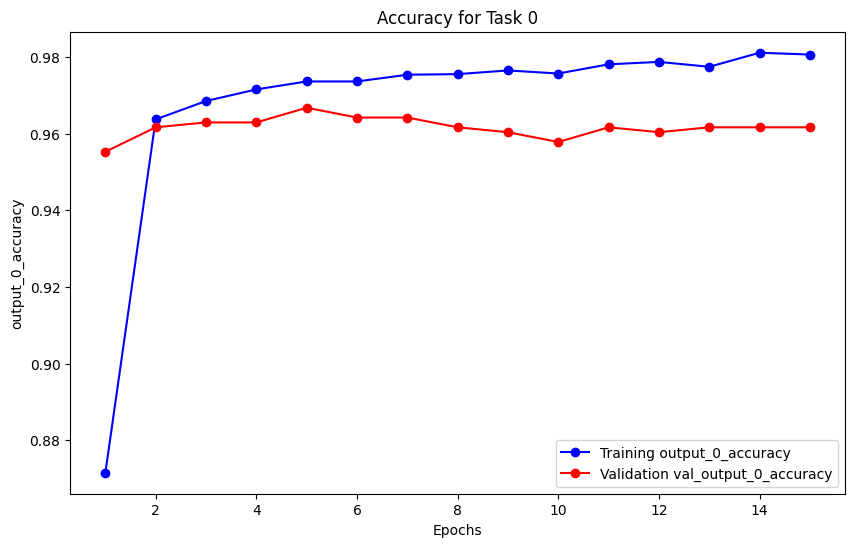

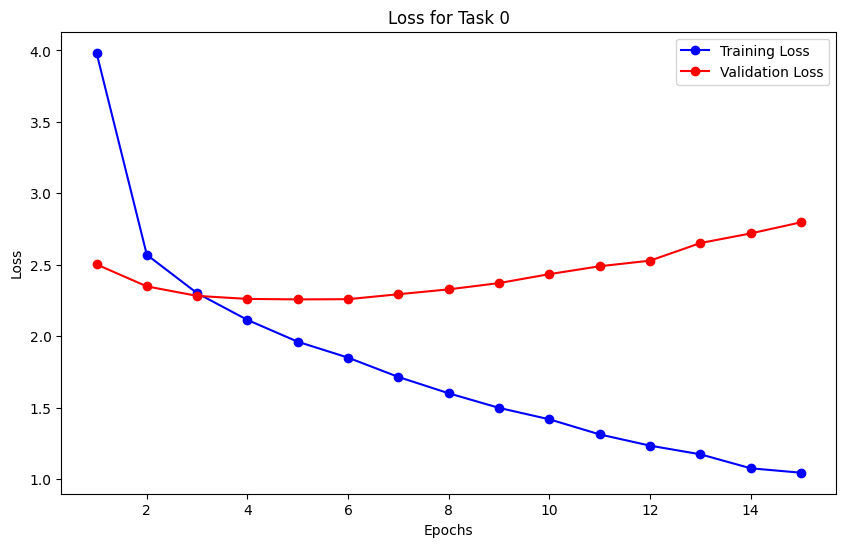

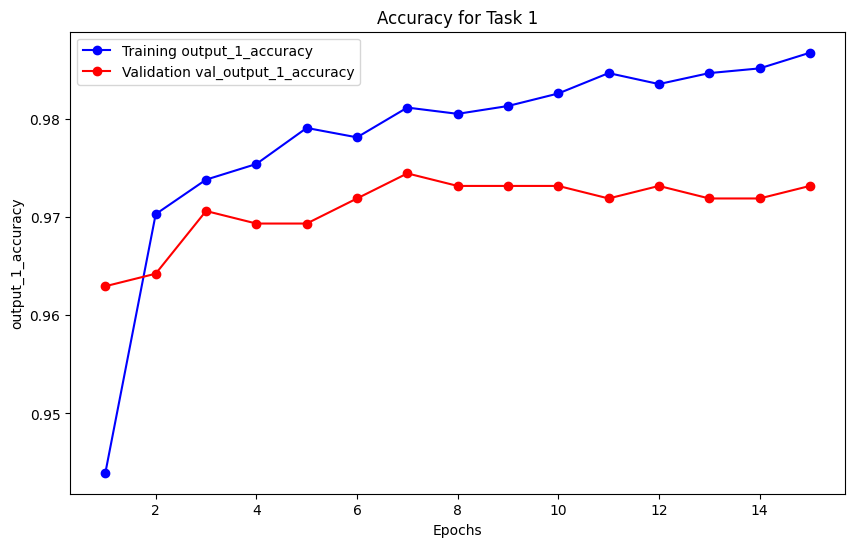

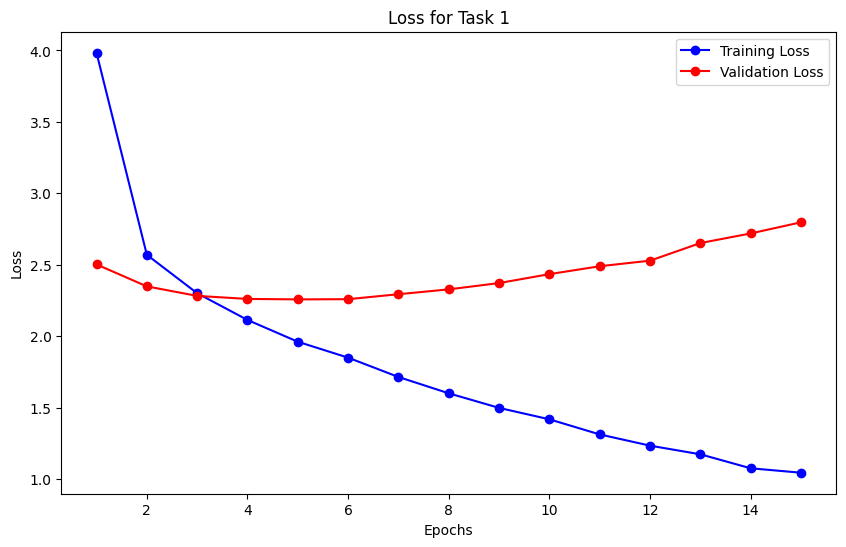

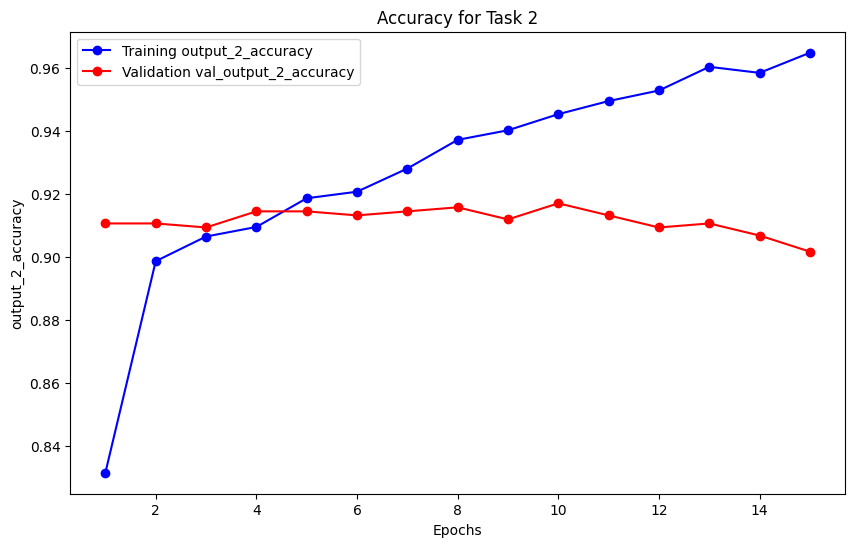

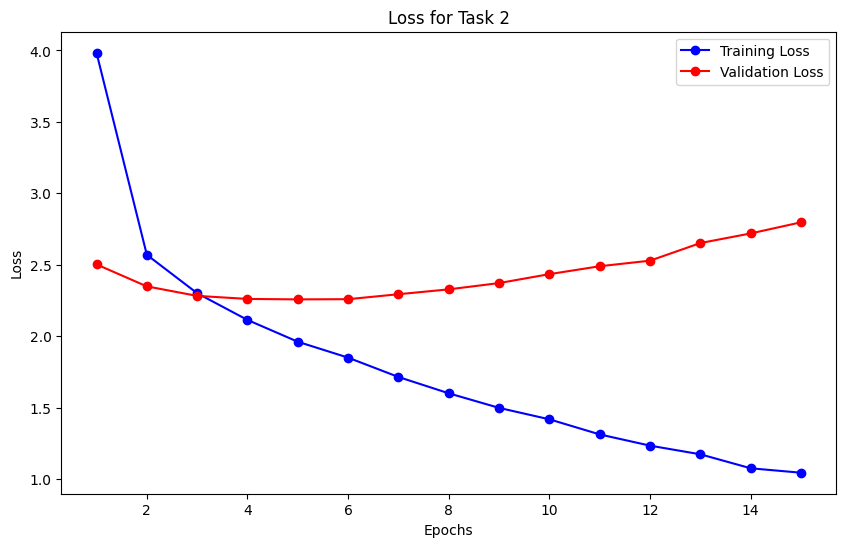

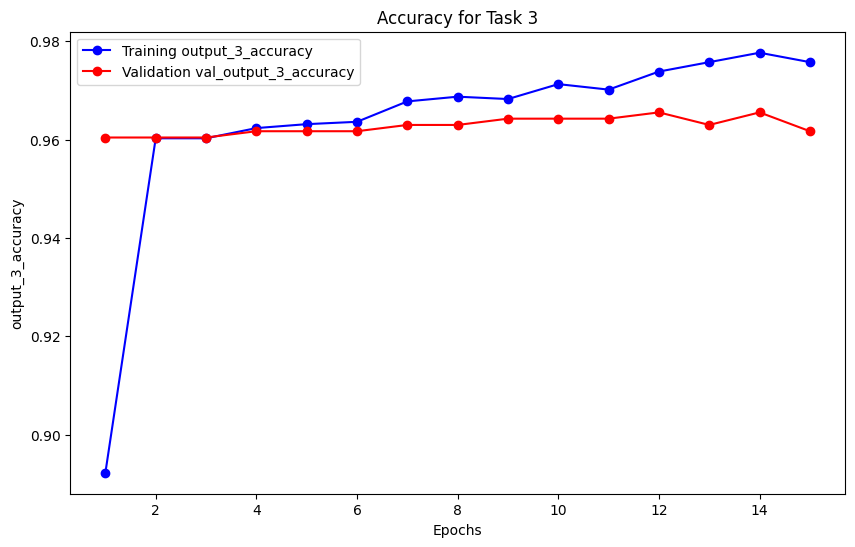

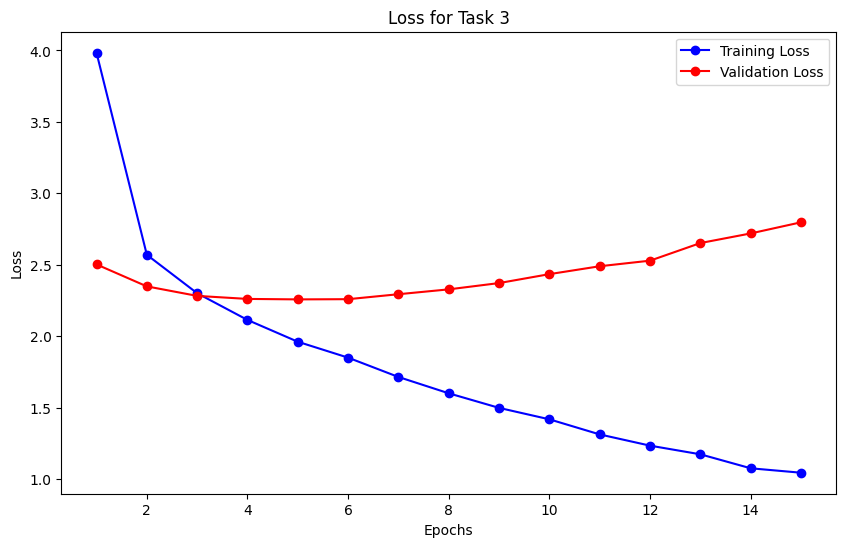

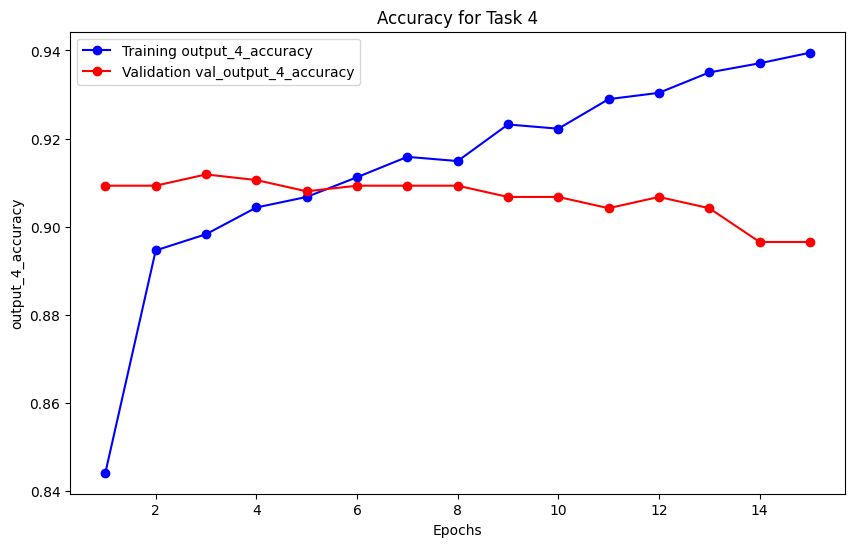

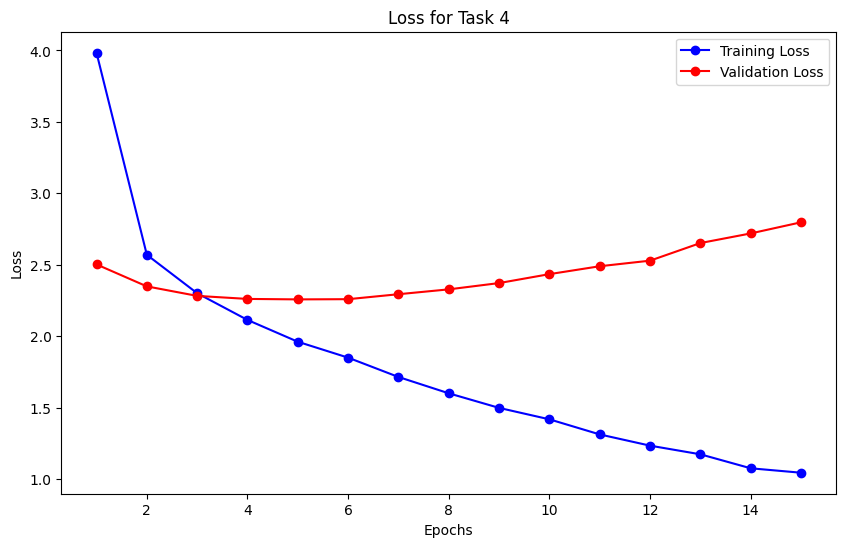

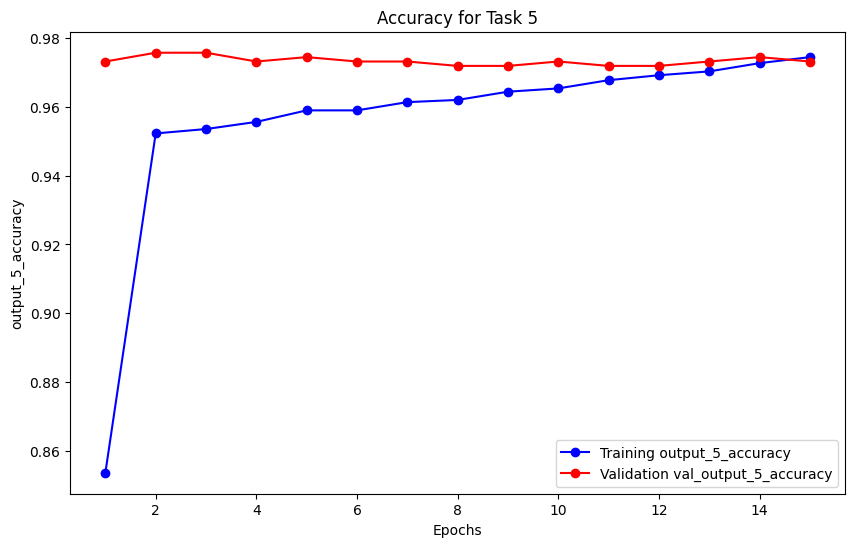

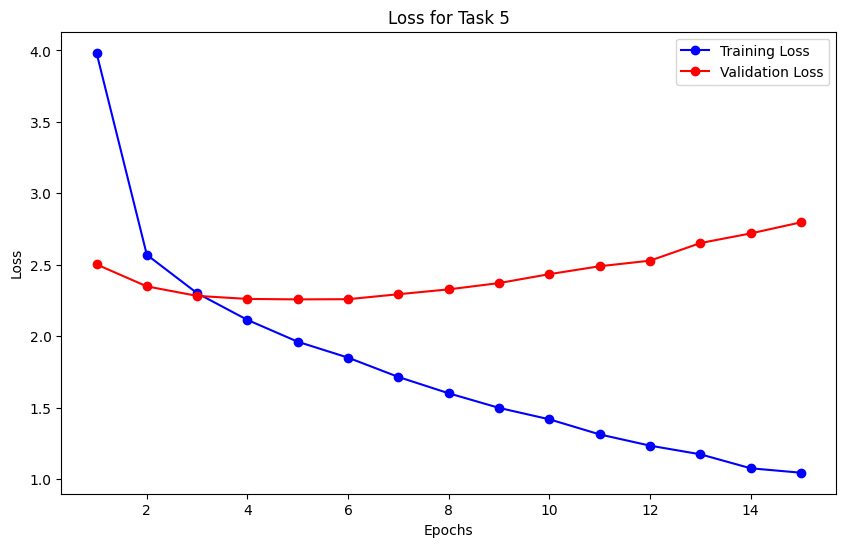

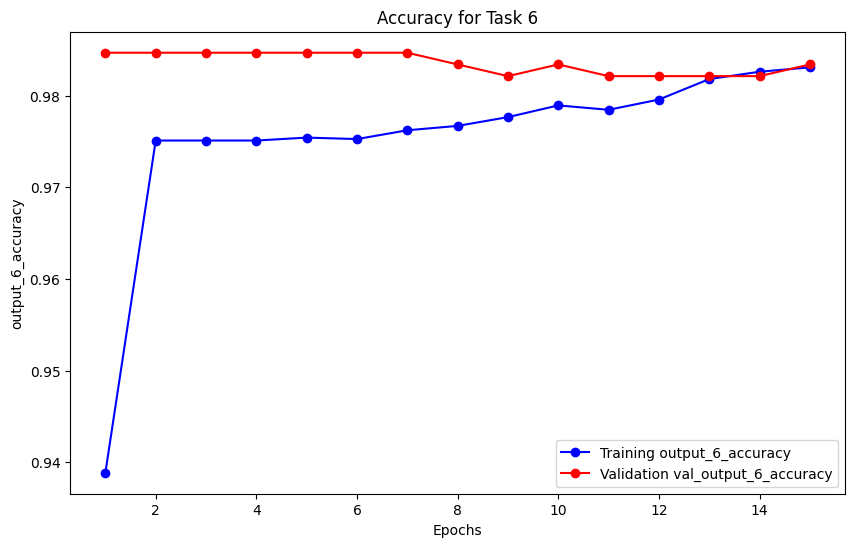

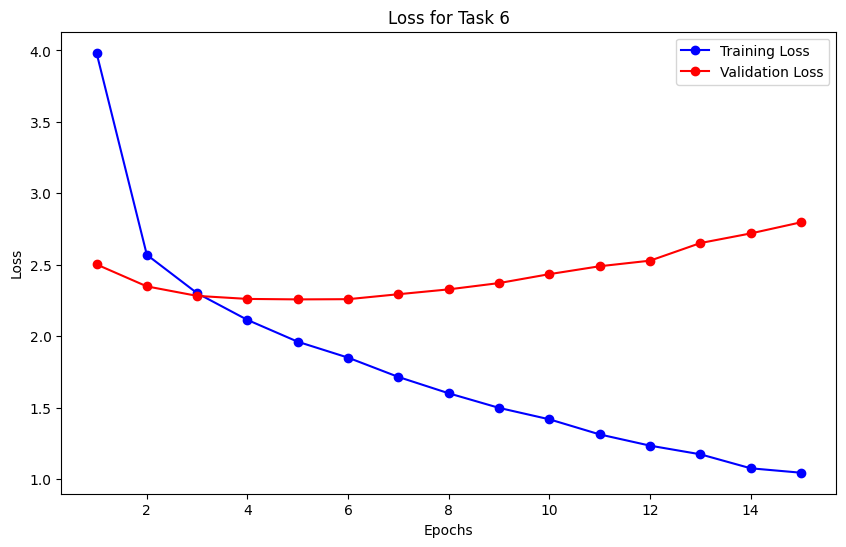

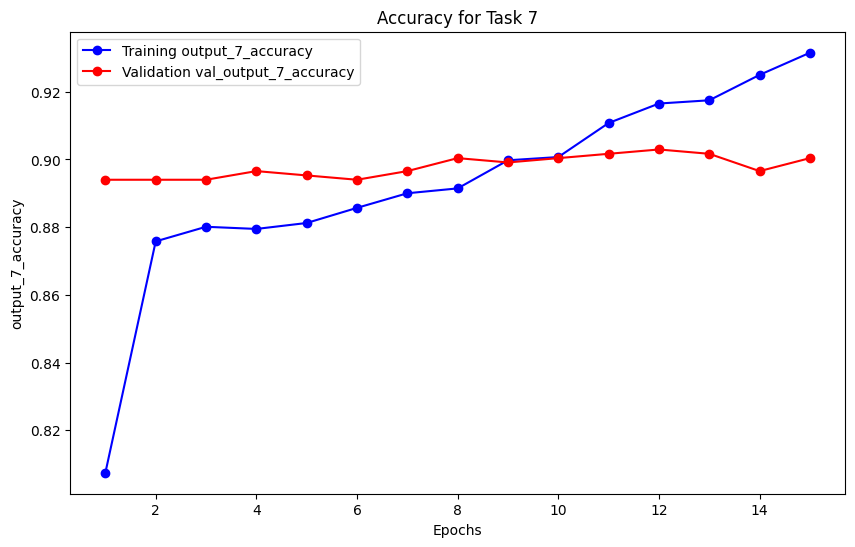

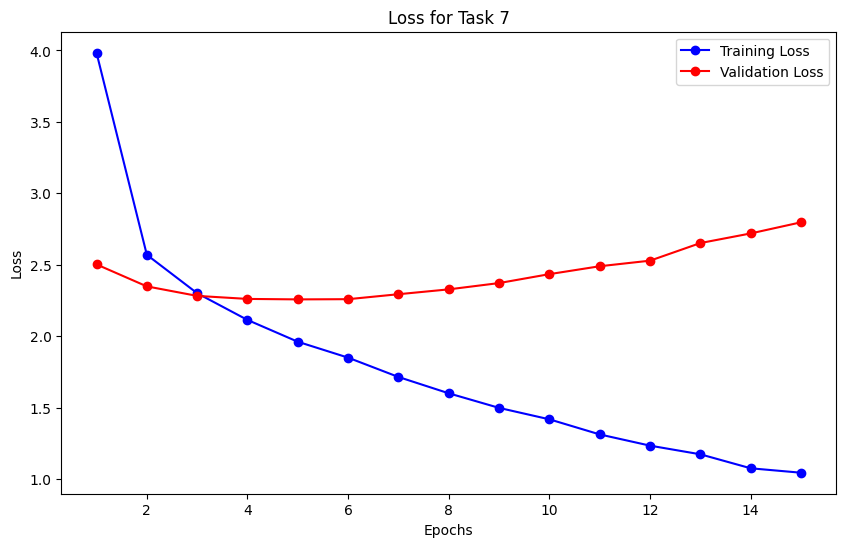

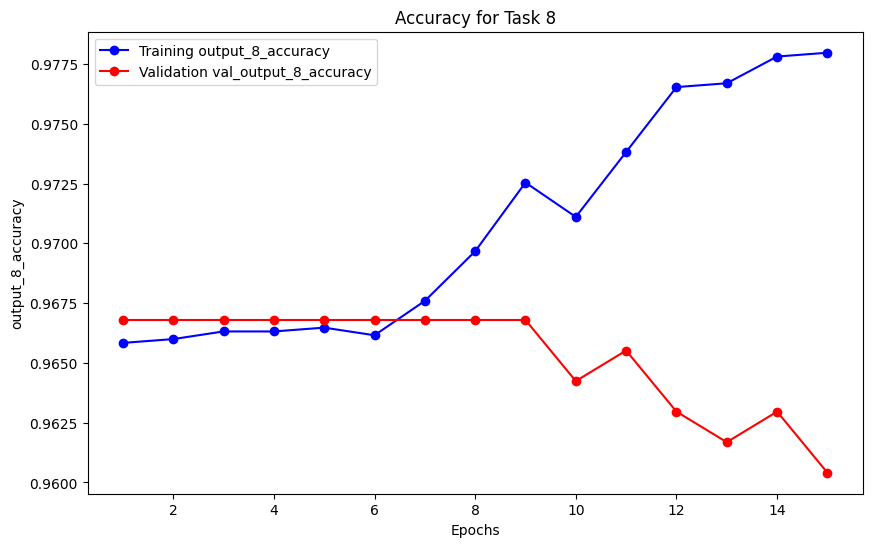

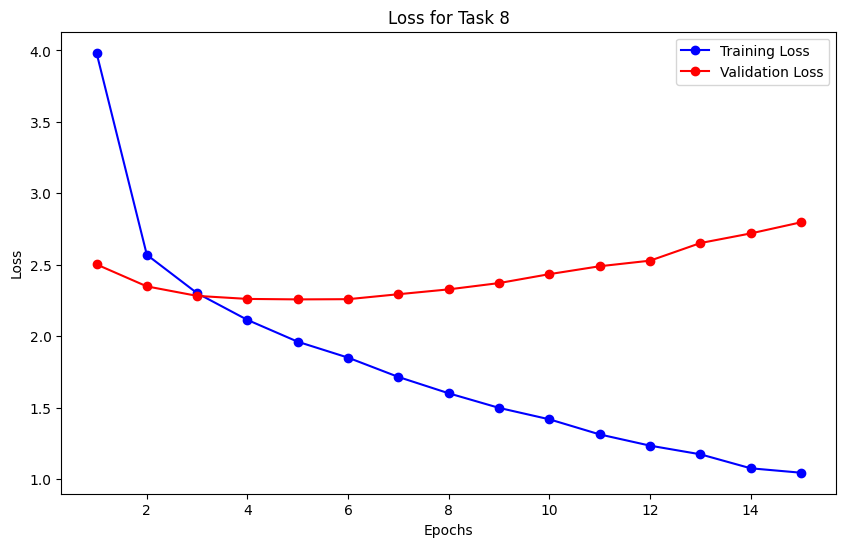

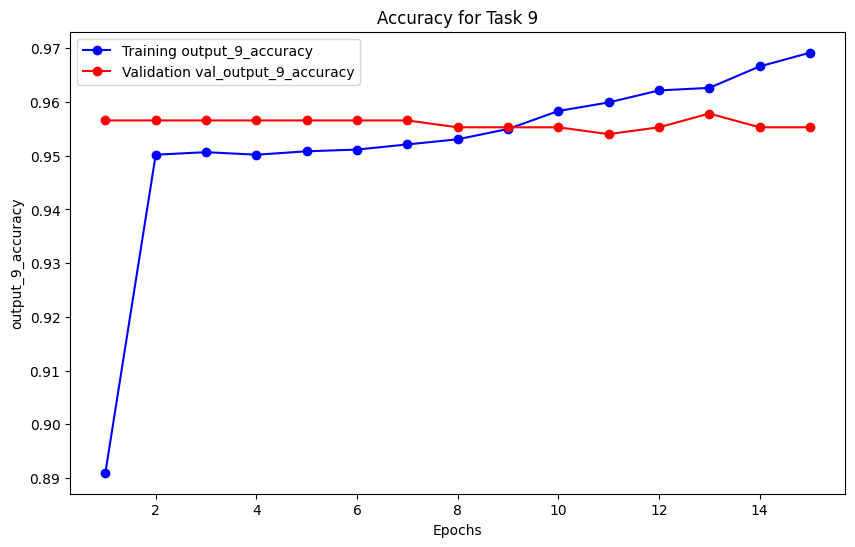

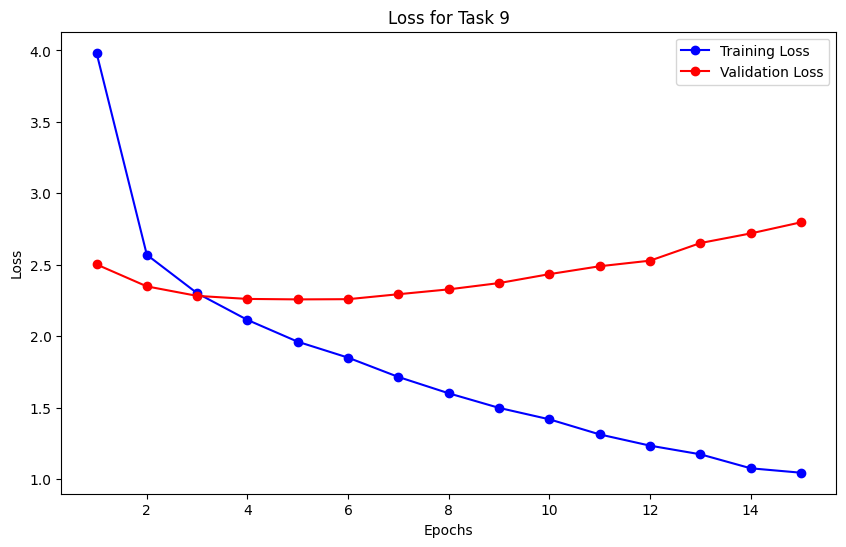

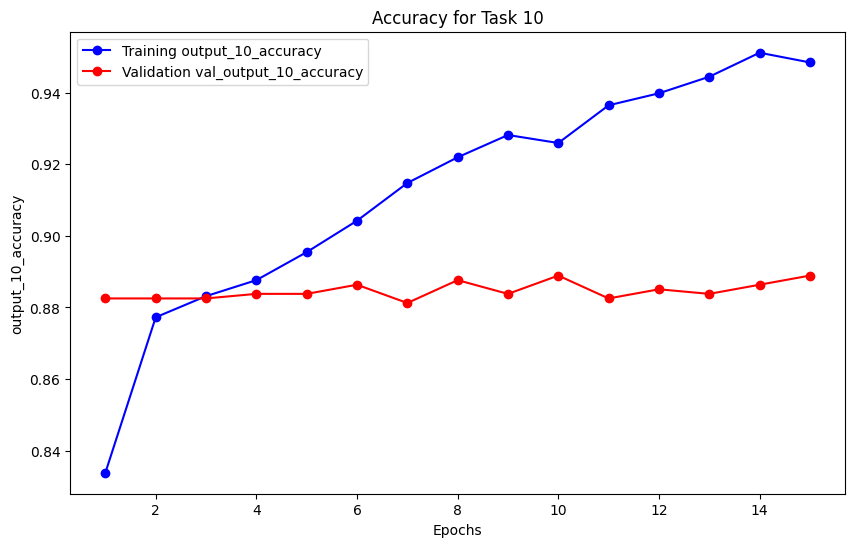

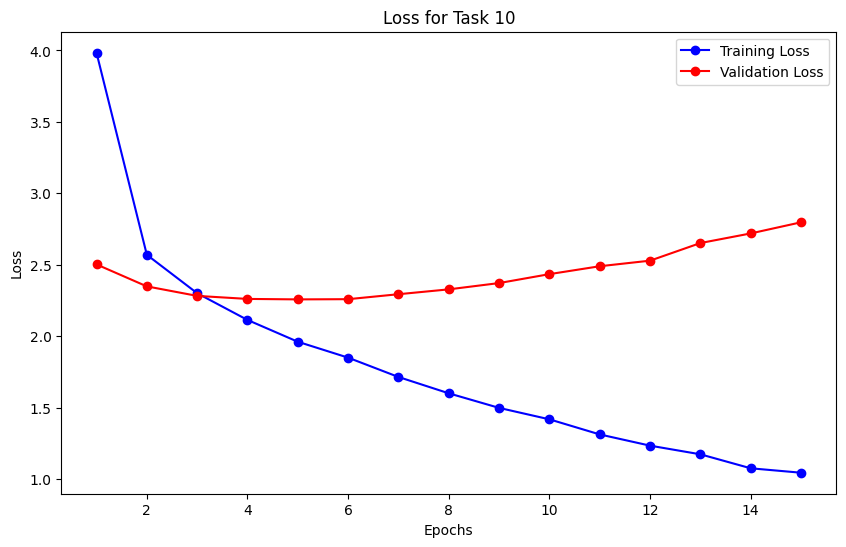

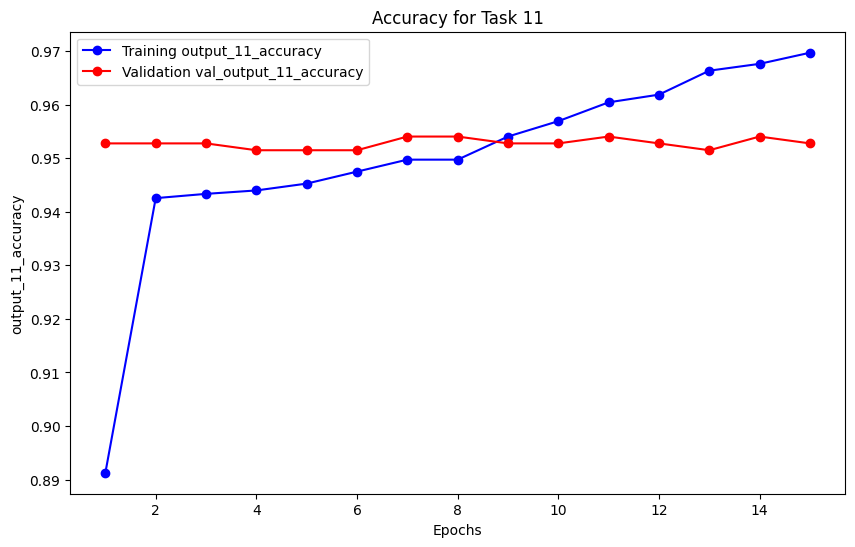

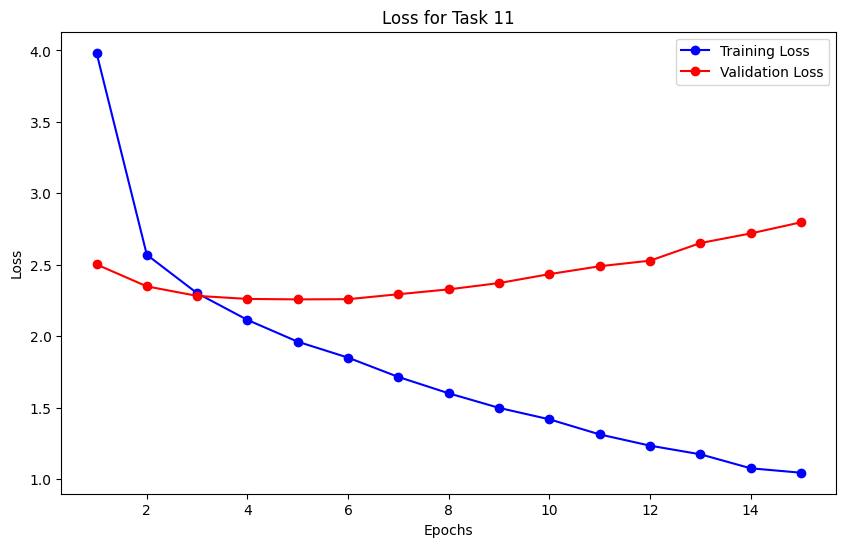

In [35]:
for idx in range(len(tasks)):
    acc_key = f'output_{idx}_accuracy'
    val_acc_key = f'val_output_{idx}_accuracy'
    loss_key = f'output_{idx}_loss'
    val_loss_key = f'val_output_{idx}_loss'

    # Plot accuracy
    plot_metrics(history.history, acc_key, val_acc_key, f'Accuracy for Task {idx}')
    # Plot loss
    plot_overall_loss(history.history, f'Loss for Task {idx}')

## Random Forest

Prepare data for preprocessing

In [36]:
X_train = train_dataset.X
y_train = np.squeeze(train_dataset.y[:, 0])  # Modify if handling multiple tasks
X_valid = valid_dataset.X
y_valid = np.squeeze(valid_dataset.y[:, 0])

Handling missing values with imputation

In [37]:
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_valid = imputer.transform(X_valid)

Feature Selection

In [38]:
selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
X_train = selector.fit_transform(X_train, y_train)
X_valid = selector.transform(X_valid)

Data Augmentation using SMOTE for balancing the dataset

In [39]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

Normalization and Scaling

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

Define parameter grid

In [41]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Define scoring metrics

In [42]:
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score)
}

Setup the GridSearchCV object

In [43]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=scoring, refit='AUC', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'F1': make_scorer(f1_score, response_method='predict'),
                      'Precision': make_scorer(precision_score, response_method='predict'),
                      'Recall': make_scorer(recall_score, response_method='predict')},
             verbose=1)

Best model

In [44]:
best_model = grid_search.best_estimator_

Predict probabilities for the validation set

In [45]:
valid_probabilities = best_model.predict_proba(X_valid)[:, 1]
valid_predictions = best_model.predict(X_valid)

Calculate metrics

In [46]:
valid_auc = roc_auc_score(y_valid, valid_probabilities)
valid_accuracy = accuracy_score(y_valid, valid_predictions)
valid_precision = precision_score(y_valid, valid_predictions)
valid_recall = recall_score(y_valid, valid_predictions)
valid_f1 = f1_score(y_valid, valid_predictions)

print(f"Validation ROC AUC: {valid_auc}")
print(f"Validation Accuracy: {valid_accuracy}")
print(f"Validation Precision: {valid_precision}")
print(f"Validation Recall: {valid_recall}")
print(f"Validation F1 Score: {valid_f1}")

Validation ROC AUC: 0.7585179526355997
Validation Accuracy: 0.9680715197956578
Validation Precision: 0.7777777777777778
Validation Recall: 0.4
Validation F1 Score: 0.5283018867924528


Convert the results to a DataFrame

In [47]:
results_df = pd.DataFrame(grid_search.cv_results_)

Plotting

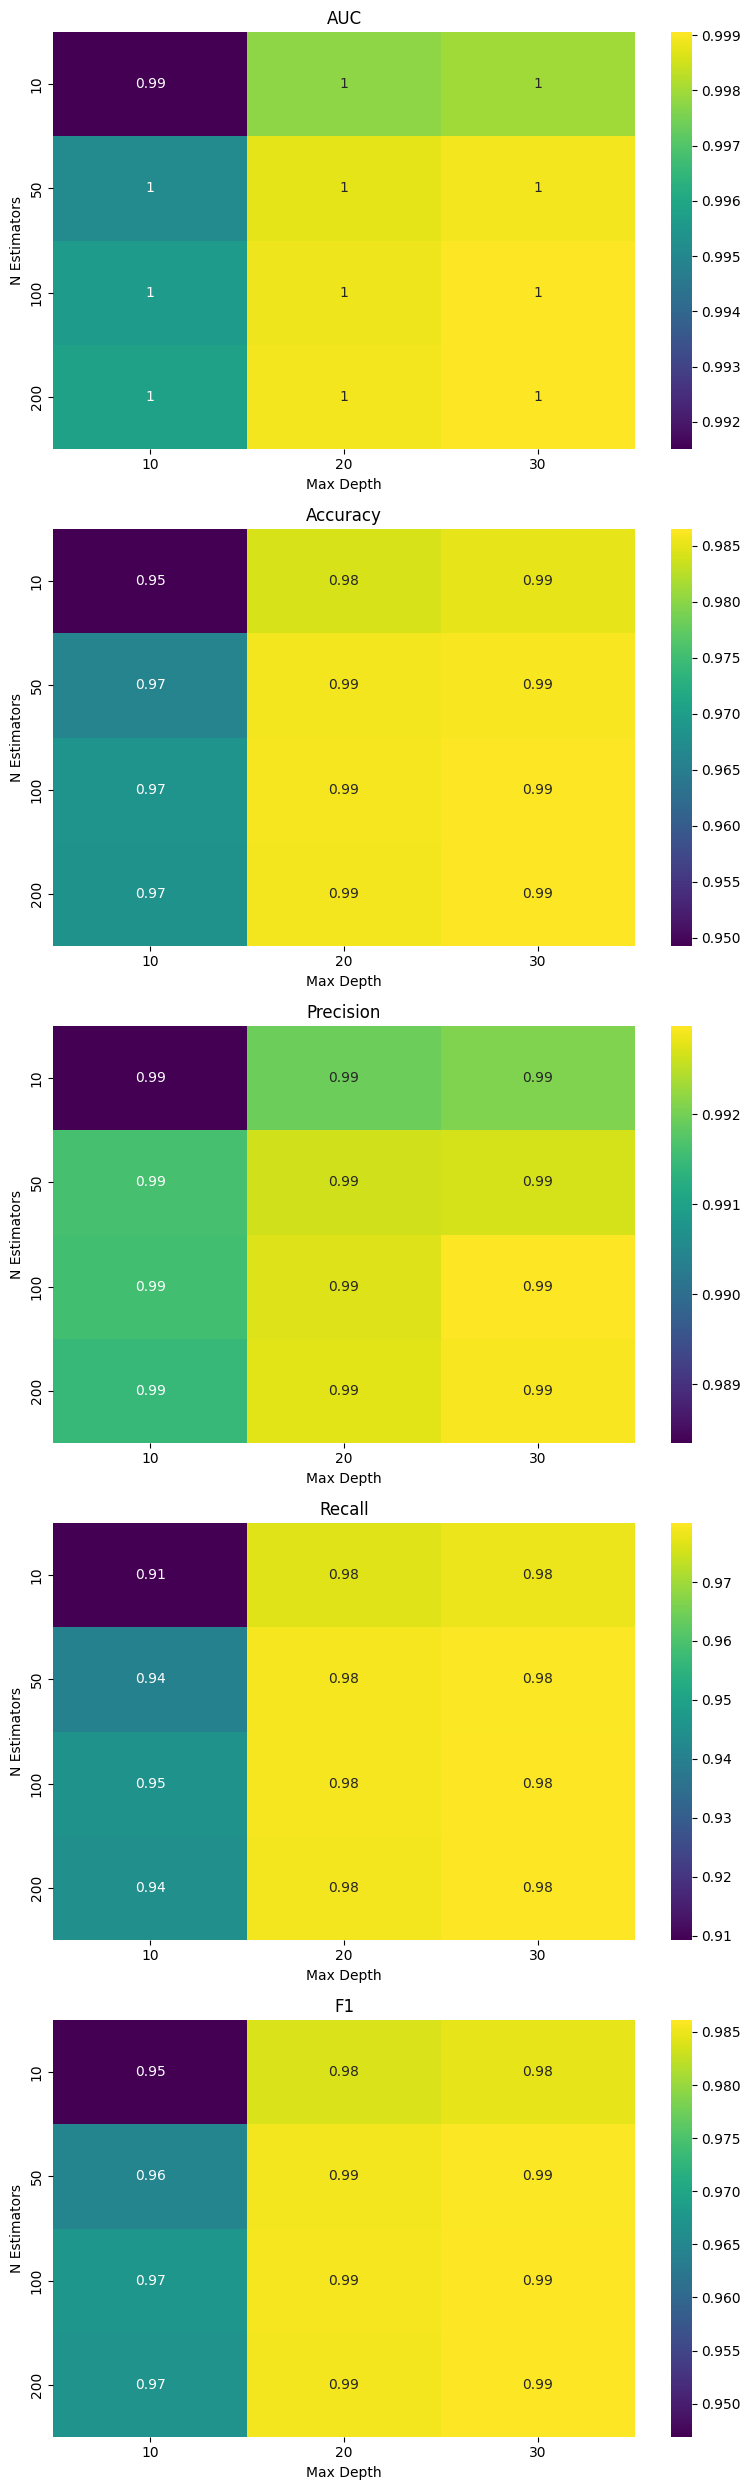

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Mean CV ROC AUC: 0.9993111839009956


In [48]:
metrics = ['mean_test_AUC', 'mean_test_Accuracy', 'mean_test_Precision', 'mean_test_Recall', 'mean_test_F1']
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 5 * len(metrics)))

for ax, metric in zip(axes, metrics):
    pivot = results_df.pivot_table(values=metric, index='param_n_estimators', columns='param_max_depth')
    sns.heatmap(pivot, annot=True, cmap='viridis', ax=ax)
    ax.set_title(metric.replace('mean_test_', '').replace('_', ' '))
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('N Estimators')

plt.tight_layout()
plt.show()

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Mean CV ROC AUC:", grid_search.best_score_)

## Logistic Regression

Prepare the data

In [49]:
X_train = train_dataset.X
y_train = np.squeeze(train_dataset.y[:, 0])  # Adjust index based on the task
X_valid = valid_dataset.X
y_valid = np.squeeze(valid_dataset.y[:, 0])

Preprocessing and Logistic Regression pipeline

In [50]:
pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('smote', SMOTE(random_state=42)),
    ('logistic', LogisticRegression(random_state=42))
])

Define hyperparameters for logistic regression

In [51]:
param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10],
    'logistic__penalty': ['l1', 'l2'],
    'logistic__solver': ['liblinear']  # 'saga' can be used for larger datasets or different regularization
}

Scorer dictionary

In [52]:
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score)
}

Setup the GridSearchCV object for the logistic regression model

In [53]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring=scoring, refit='AUC', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=50)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logistic',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logistic__C': [0.001, 0.01, 0.1, 1, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'logistic__solver': ['liblinear']},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'F1': make_scorer(f1_score, response_method='predict'),
                      'Precision': make_scorer(precision_score, response_method='predict'),
                      'Recall': make_scorer(recall_score, response_method='predict')},
             verbose=1)

Evaluate the best model

In [54]:
best_model = grid_search.best_estimator_
valid_probabilities = best_model.predict_proba(X_valid)[:, 1]
valid_predictions = best_model.predict(X_valid)

Calculate and print performance metrics

In [55]:
valid_auc = roc_auc_score(y_valid, valid_probabilities)
valid_accuracy = accuracy_score(y_valid, valid_predictions)
valid_precision = precision_score(y_valid, valid_predictions)
valid_recall = recall_score(y_valid, valid_predictions)
valid_f1 = f1_score(y_valid, valid_predictions)

print(f"Validation ROC AUC: {valid_auc}")
print(f"Validation Accuracy: {valid_accuracy}")
print(f"Validation Precision: {valid_precision}")
print(f"Validation Recall: {valid_recall}")
print(f"Validation F1 Score: {valid_f1}")

Validation ROC AUC: 0.7377769289533995
Validation Accuracy: 0.8582375478927203
Validation Precision: 0.16666666666666666
Validation Recall: 0.5428571428571428
Validation F1 Score: 0.2550335570469799


Extract results and correct column names for visualization

In [56]:
results = pd.DataFrame(grid_search.cv_results_)
important_columns = [
    'param_logistic__C', 
    'param_logistic__penalty', 
    'mean_test_AUC', 
    'mean_test_Accuracy', 
    'mean_test_Precision', 
    'mean_test_Recall', 
    'mean_test_F1'
]

Plotting

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_15955/462574267.py:2: FutureWarning: The provided callable <function max at 0x1116a7880> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  pivot_auc = results_filtered.pivot_table(index='param_logistic__C', columns='param_logistic__penalty', values='mean_test_AUC', aggfunc=np.max)


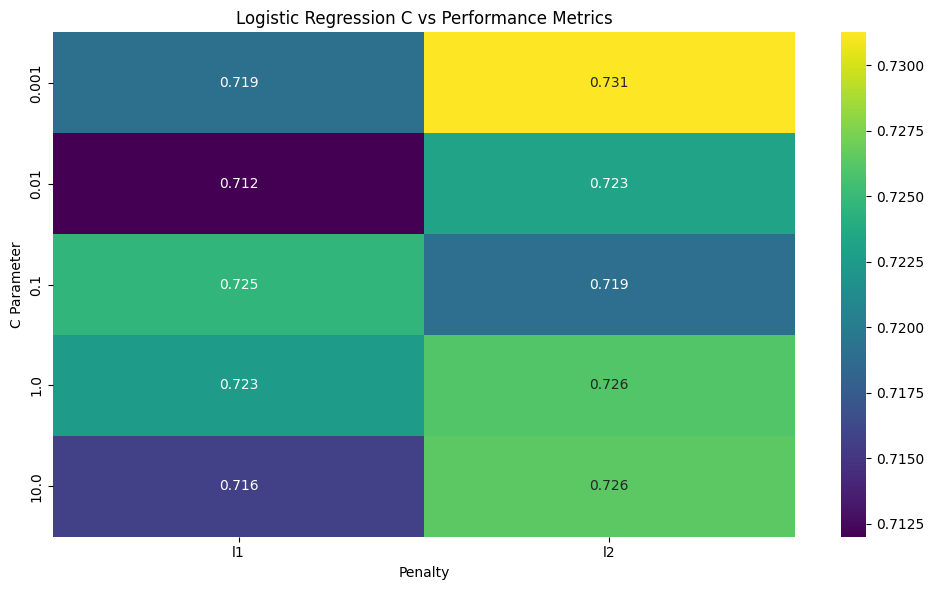

In [57]:
results_filtered = results[important_columns]
pivot_auc = results_filtered.pivot_table(index='param_logistic__C', columns='param_logistic__penalty', values='mean_test_AUC', aggfunc=np.max)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_auc, annot=True, fmt=".3f", cmap='viridis')
plt.title('Logistic Regression C vs Performance Metrics')
plt.xlabel('Penalty')
plt.ylabel('C Parameter')
plt.tight_layout()
plt.show()

## Tox21 dataset informations

Load dataset

In [59]:
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21()
train_dataset, valid_dataset, test_dataset = tox21_datasets

Show some crucial info

In [60]:
print("Number of tasks:", len(tox21_tasks))
print("Tasks:", tox21_tasks)
print("Number of compounds in the training set:", len(train_dataset.X))
print("Number of features per compound:", train_dataset.X.shape[1])
print("Number of features", train_dataset.X.shape[1])

Number of tasks: 12
Tasks: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
Number of compounds in the training set: 6264
Number of features per compound: 1024
Number of features 1024


Prepare data for visualisation

In [61]:
# Extract SMILES from the dataset for further analysis
smiles = train_dataset.ids  # This assumes that the IDs are SMILES strings

# Compute molecular descriptors
mol_weights = []
log_p_values = []
for sm in smiles:
    mol = Chem.MolFromSmiles(sm)
    if mol is not None:
        mol_weights.append(Descriptors.MolWt(mol))
        log_p_values.append(Descriptors.MolLogP(mol))

# Create a DataFrame for easier plotting
mol_data = pd.DataFrame({'Molecular Weight': mol_weights, 'LogP': log_p_values})

[16:05:00] WARNING: not removing hydrogen atom without neighbors


Visualise dataset informations

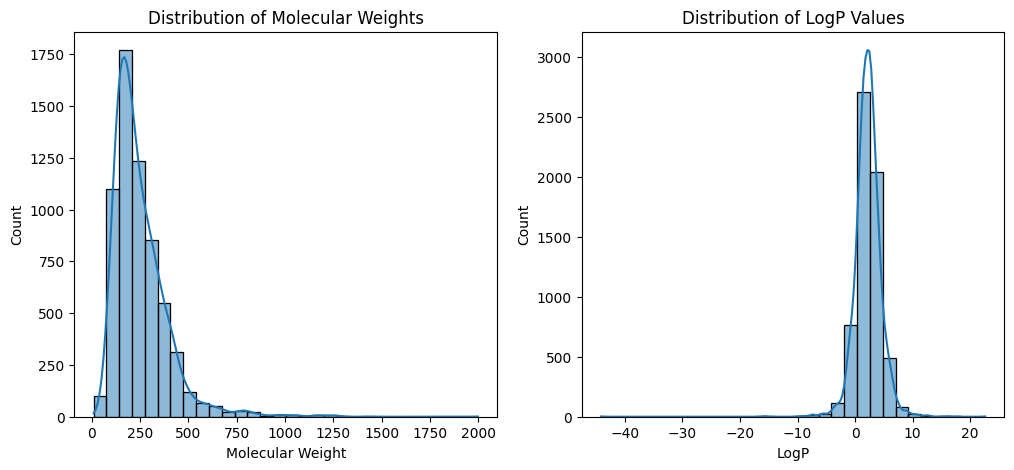

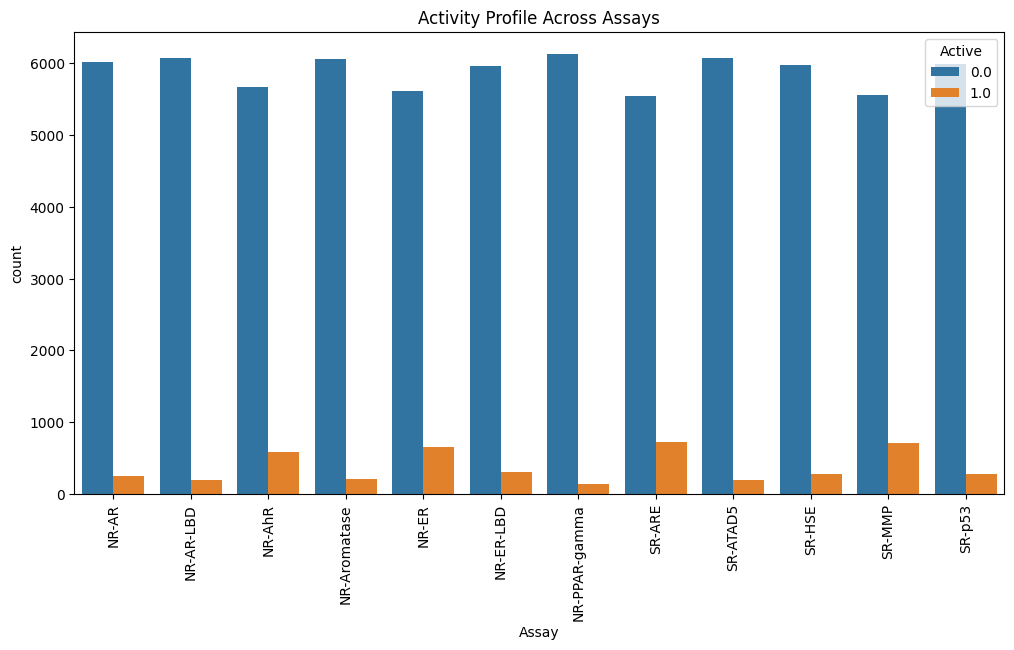

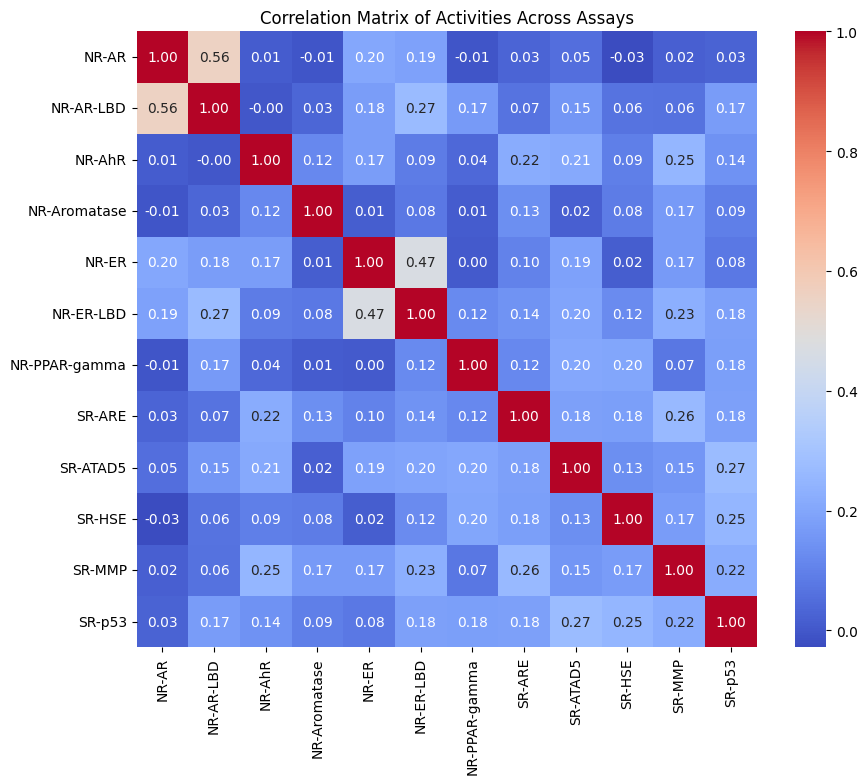

In [62]:
# Plot distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(mol_data['Molecular Weight'], bins=30, kde=True)
plt.title('Distribution of Molecular Weights')

plt.subplot(1, 2, 2)
sns.histplot(mol_data['LogP'], bins=30, kde=True)
plt.title('Distribution of LogP Values')
plt.show()

# Assuming 'train_dataset.y' contains the binary labels for each assay
activity_data = pd.DataFrame(train_dataset.y, columns=tox21_tasks)

# Melt the DataFrame to use with seaborn
activity_melted = activity_data.melt(var_name='Assay', value_name='Active')

plt.figure(figsize=(12, 6))
sns.countplot(data=activity_melted, x='Assay', hue='Active')
plt.title('Activity Profile Across Assays')
plt.xticks(rotation=90)
plt.show()

# Compute correlations
corr = activity_data.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Activities Across Assays')
plt.show()